In [1]:
from lib import *
import pandas as pd
import matplotlib.pyplot as plt

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


#dfs = load_data_bq()
dfs = load_data_db()

df_contratos = dfs
df_contratos = df_contratos["dias_agenciados"]

Conexão estabelecida com sucesso!


In [2]:
df_eventos = pd.read_csv(
    "data/Clientes Estratégicos - B2B x Conteúdo Personalizado(base).csv", 
    sep=";", 
    encoding="latin1"  # or "cp1252"
)


df_eventos.columns = ['cnpj', 'ID', 'NOME TRANSPORTADORA(S)', 'Status', 'Tier', 'CONTROLE',
       'CONTEÚDO PERSONALIZADO', 'TELEMETRIA', 'CAVALEIRO', 'TIPO',
       'DIAS DE CONTRATO', 'Data Telemetria', 'Data Conteúdo Personalizado']


In [3]:
df_eventos = df_eventos.fillna(0)

In [4]:
import pandas as pd
import re
df = df_eventos

# Função para limpar a string e converter para lista de inteiros, ignorando itens inválidos
def parse_ids(s):
    # Remove colchetes se houver
    s_clean = re.sub(r'[\[\]]', '', s)
    result = []
    for item in s_clean.split(','):
        item_str = item.strip()
        try:
            result.append(int(item_str))
        except ValueError:
            # Ignora o item se não puder ser convertido para inteiro (ex.: '#N/D')
            continue
    return result

# Cria uma nova coluna com a lista de IDs
df['ID_list'] = df['ID'].apply(parse_ids)

# Explode a coluna 'ID_list' para transformar cada ID em uma nova linha
df_exploded = df.explode('ID_list')

# Descarta a coluna original 'ID' para evitar duplicidade
df_exploded = df_exploded.dropna(axis=0)
df_exploded = df_exploded.drop(columns=['ID'])

# Renomeia a coluna explode para "ID"
df_exploded = df_exploded.rename(columns={'ID_list': 'ID'})

# Converte a coluna de ID para inteiro (agora todos os valores são provenientes da lista)
df_exploded['ID'] = df_exploded['ID'].astype(int)



df_contratos = df_contratos.merge(df_exploded, left_on="company_id", right_on="ID")
# Converter a coluna created_at para datetime, se já não estiver no formato adequado
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'])

# Criar as novas colunas com o mês e o ano
df_contratos['mes'] = df_contratos['created_at'].dt.month
df_contratos['ano'] = df_contratos['created_at'].dt.year
df_contratos['dia'] = df_contratos['created_at'].dt.day
# Exibe o DataFrame resultante
df_contratos.head()


,created_at,company_id,contract_days,cnpj,NOME TRANSPORTADORA(S),Status,Tier,CONTROLE,CONTEÚDO PERSONALIZADO,TELEMETRIA,CAVALEIRO,TIPO,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia
0,2023-04-28 15:50:15,423,1.0,16661925,OPERAÇÕES AMBEV,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,33,0,0,423,4,2023,28
1,2023-05-10 14:20:02,347,17.0,20682,TRANSPORTADORA SIDER LTDA,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,369,0,0,347,5,2023,10
2,2022-11-28 16:22:58,335,12.0,23850588,TRANSPANORAMA,Recorrente,2,Não,Sim,Não,GALAHAD,Cliente Estratégico,347,0,25/09/2024,335,11,2022,28
3,2022-11-28 16:37:00,159,21.0,29081265,G2L LOGISTICA,Recorrente,4,Não,Não,Sim,GALAHAD,Cliente Estratégico,1227,02/02/2024,0,159,11,2022,28
4,2022-09-28 17:33:41,249,5.0,23850588,TOZZO,Recorrente,2,Não,Sim,Sim,CONSTANTINE,Cliente Estratégico,885,21/06/2024,29/08/2024,249,9,2022,28


In [5]:
import pandas as pd

# Converter a coluna created_at para datetime
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'])
df_contratos = df_contratos.sort_values("created_at")
# Calcular a data mínima para cada company_id
df_contratos['min_date'] = df_contratos.groupby('company_id')['created_at'].transform('min')

# Quando Data Telemetria ou Data Conteúdo Personalizado for igual a 0, transformar em NaT
df_contratos.loc[df_contratos['Data Telemetria'] == 0, 'Data Telemetria'] = np.nan
df_contratos.loc[df_contratos['Data Conteúdo Personalizado'] == 0, 'Data Conteúdo Personalizado'] = np.nan



# Calcular a diferença em dias entre created_at e a data mínima para o mesmo company_id
df_contratos['diff_days'] = (df_contratos['created_at'] - df_contratos['min_date']).dt.days
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'], errors='coerce')
df_contratos['Data Telemetria'] = pd.to_datetime(df_contratos['Data Telemetria'], dayfirst=True, errors='coerce')
df_contratos['Data Conteúdo Personalizado'] = pd.to_datetime(df_contratos['Data Conteúdo Personalizado'], dayfirst=True, errors='coerce')

df_contratos.describe()


,created_at,company_id,contract_days,cnpj,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia,min_date,diff_days
count,142172,142172.000000,142171.000000,1.421720e+05,142172.000000,27480,29801,142172.000000,142172.000000,142172.000000,142172.000000,142172,142172.000000
mean,2024-01-30 21:05:55.678016512,1115.780168,7.253476,4.012568e+07,681.101061,2024-08-24 04:14:37.205240064,2024-10-15 00:40:38.253749504,1115.780168,6.741925,2023.561404,15.892412,2023-02-10 02:07:50.065385472,354.271819
min,2019-12-09 11:40:33,5.000000,-14.000000,0.000000e+00,-6.000000,2024-01-01 00:00:00,2024-04-17 00:00:00,5.000000,1.000000,2019.000000,1.000000,2019-12-09 11:40:33,0.000000
25%,2023-09-06 12:40:32.500000,423.000000,1.000000,1.662217e+07,0.000000,2024-06-21 00:00:00,2024-08-29 00:00:00,423.000000,3.000000,2023.000000,8.000000,2022-08-04 08:53:28,125.000000
50%,2024-03-23 09:30:35.500000,953.000000,3.000000,2.385059e+07,60.000000,2024-09-09 00:00:00,2024-09-27 00:00:00,953.000000,7.000000,2024.000000,16.000000,2023-05-12 17:14:53,272.000000
75%,2024-09-13 14:22:50.750000128,1631.000000,9.000000,7.341033e+07,401.000000,2024-11-28 00:00:00,2025-01-10 00:00:00,1631.000000,10.000000,2024.000000,24.000000,2023-10-14 13:47:08,489.000000
max,2025-03-05 17:46:19,3916.000000,273.000000,9.840000e+07,9197.000000,2025-02-03 00:00:00,2025-03-07 00:00:00,3916.000000,12.000000,2025.000000,31.000000,2025-01-25 17:40:34,1844.000000
std,NaN,855.560648,9.831532,2.859231e+07,1808.022643,NaN,NaN,855.560648,3.639810,0.875937,8.893628,NaN,311.595262


In [6]:
df = df_contratos.copy()

In [7]:
import pandas as pd
import numpy as np

# Suponha que o DataFrame original já esteja carregado em "df"
# Exemplo: df = pd.read_csv("seu_arquivo.csv")


# =======================================================================
# Cálculo dos diff_dates em DIAS para cada grupo
# =======================================================================

# 1. Empresas sem telemetria e sem conteúdo personalizado
df['diff_date_sem_tp_sem_cp_days'] = np.where(
    (df['TELEMETRIA'] == 'Não') & (df['CONTEÚDO PERSONALIZADO'] == 'Não'),
    df['diff_days'],
    np.nan
)

# 2. Empresas com telemetria, antes da contratação 
# (primeiro log < Data Telemetria: diff = Data Telemetria - created_at)
df['diff_date_antes_tp_days'] = np.where(
    (df['TELEMETRIA'] == 'Sim') &
    (df['Data Telemetria'].notna()) &
    (df['created_at'] < df['Data Telemetria']),
    df['diff_days'],
    np.nan
)

# 3. Empresas com telemetria, após a contratação 
# (primeiro log >= Data Telemetria: diff = diff_days - (created_at - Data Telemetria))
df['diff_date_depois_tp_days'] = np.where(
    (df['TELEMETRIA'] == 'Sim') &
    (df['Data Telemetria'].notna()) &
    (df['created_at'] >= df['Data Telemetria']),
    (df['created_at'] - df['Data Telemetria']).dt.days,
    np.nan
)

# 4. Empresas com conteúdo personalizado, antes da contratação 
# (primeiro log < Data Conteúdo Personalizado: diff = Data Conteúdo Personalizado - created_at)
df['diff_date_antes_cp_days'] = np.where(
    (df['CONTEÚDO PERSONALIZADO'] == 'Sim') &
    (df['Data Conteúdo Personalizado'].notna()) &
    (df['created_at'] < df['Data Conteúdo Personalizado']),
    df['diff_days'],
    np.nan
)

# 5. Empresas com conteúdo personalizado, após a contratação 
# (primeiro log >= Data Conteúdo Personalizado: diff = diff_days - (created_at - Data Conteúdo Personalizado))
df['diff_date_depois_cp_days'] = np.where(
    (df['CONTEÚDO PERSONALIZADO'] == 'Sim') &
    (df['Data Conteúdo Personalizado'].notna()) &
    (df['created_at'] >= df['Data Conteúdo Personalizado']),
    (df['created_at'] - df['Data Conteúdo Personalizado']).dt.days,
    np.nan
)

# =======================================================================
# Conversão dos valores de dias para MESES (aproximando 30 dias por mês)
# =======================================================================
conversion_factor = 30

df['diff_date_sem_tp_sem_cp_months'] = df['diff_date_sem_tp_sem_cp_days'] / conversion_factor
df['diff_date_antes_tp_months']      = df['diff_date_antes_tp_days'] / conversion_factor
df['diff_date_depois_tp_months']       = df['diff_date_depois_tp_days'] / conversion_factor
df['diff_date_antes_cp_months']        = df['diff_date_antes_cp_days'] / conversion_factor
df['diff_date_depois_cp_months']         = df['diff_date_depois_cp_days'] / conversion_factor

# Exibe as primeiras linhas para conferir as novas colunas
cols_novas = [
    'diff_date_sem_tp_sem_cp_days', 'diff_date_sem_tp_sem_cp_months',
    'diff_date_antes_tp_days',      'diff_date_antes_tp_months',
    'diff_date_depois_tp_days',       'diff_date_depois_tp_months',
    'diff_date_antes_cp_days',        'diff_date_antes_cp_months',
    'diff_date_depois_cp_days',         'diff_date_depois_cp_months'
]
df.describe()

,created_at,company_id,contract_days,cnpj,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia,min_date,diff_days,diff_date_sem_tp_sem_cp_days,diff_date_antes_tp_days,diff_date_depois_tp_days,diff_date_antes_cp_days,diff_date_depois_cp_days,diff_date_sem_tp_sem_cp_months,diff_date_antes_tp_months,diff_date_depois_tp_months,diff_date_antes_cp_months,diff_date_depois_cp_months
count,142172,142172.000000,142171.000000,1.421720e+05,142172.000000,27480,29801,142172.000000,142172.000000,142172.000000,142172.000000,142172,142172.000000,104528.000000,16366.000000,11114.000000,22421.000000,7059.000000,104528.000000,16366.000000,11114.000000,22421.000000,7059.000000
mean,2024-01-30 21:05:55.678016512,1115.780168,7.253476,4.012568e+07,681.101061,2024-08-24 04:14:37.205240064,2024-10-15 00:40:38.253749504,1115.780168,6.741925,2023.561404,15.892412,2023-02-10 02:07:50.065385472,354.271819,293.752765,473.549126,130.070182,529.344944,88.280210,9.791759,15.784971,4.335673,17.644831,2.942674
min,2019-12-09 11:40:33,5.000000,-14.000000,0.000000e+00,-6.000000,2024-01-01 00:00:00,2024-04-17 00:00:00,5.000000,1.000000,2019.000000,1.000000,2019-12-09 11:40:33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-09-06 12:40:32.500000,423.000000,1.000000,1.662217e+07,0.000000,2024-06-21 00:00:00,2024-08-29 00:00:00,423.000000,3.000000,2023.000000,8.000000,2022-08-04 08:53:28,125.000000,108.000000,205.000000,56.000000,236.000000,37.000000,3.600000,6.833333,1.866667,7.866667,1.233333
50%,2024-03-23 09:30:35.500000,953.000000,3.000000,2.385059e+07,60.000000,2024-09-09 00:00:00,2024-09-27 00:00:00,953.000000,7.000000,2024.000000,16.000000,2023-05-12 17:14:53,272.000000,237.000000,431.500000,114.000000,493.000000,81.000000,7.900000,14.383333,3.800000,16.433333,2.700000
75%,2024-09-13 14:22:50.750000128,1631.000000,9.000000,7.341033e+07,401.000000,2024-11-28 00:00:00,2025-01-10 00:00:00,1631.000000,10.000000,2024.000000,24.000000,2023-10-14 13:47:08,489.000000,377.000000,705.000000,197.000000,783.000000,132.000000,12.566667,23.500000,6.566667,26.100000,4.400000
max,2025-03-05 17:46:19,3916.000000,273.000000,9.840000e+07,9197.000000,2025-02-03 00:00:00,2025-03-07 00:00:00,3916.000000,12.000000,2025.000000,31.000000,2025-01-25 17:40:34,1844.000000,1844.000000,1325.000000,425.000000,1440.000000,318.000000,61.466667,44.166667,14.166667,48.000000,10.600000
std,NaN,855.560648,9.831532,2.859231e+07,1808.022643,NaN,NaN,855.560648,3.639810,0.875937,8.893628,NaN,311.595262,262.751232,318.551866,91.527446,345.701329,60.899531,8.758374,10.618396,3.050915,11.523378,2.029984


In [8]:
# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
df_group1 = df[df['diff_date_sem_tp_sem_cp_days'].notna()]

# Grupo 2: Empresas com telemetria, antes da contratação 
df_group2 = df[df['diff_date_antes_tp_days'].notna()]

# Grupo 3: Empresas com telemetria, após a contratação 
df_group3 = df[df['diff_date_depois_tp_days'].notna()]

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
df_group4 = df[df['diff_date_antes_cp_days'].notna()]

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
df_group5 = df[df['diff_date_depois_cp_days'].notna()]

# Exemplo de visualização dos dataframes
# print("Grupo 1:")
# print(df_group1.head())

# print("\nGrupo 2:")
# print(df_group2.head())

# print("\nGrupo 3:")
# print(df_group3.head())

# print("\nGrupo 4:")
# print(df_group4.head())

# print("\nGrupo 5:")
df_group5.head()


,created_at,company_id,contract_days,cnpj,NOME TRANSPORTADORA(S),Status,Tier,CONTROLE,CONTEÚDO PERSONALIZADO,TELEMETRIA,CAVALEIRO,TIPO,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia,min_date,diff_days,diff_date_sem_tp_sem_cp_days,diff_date_antes_tp_days,diff_date_depois_tp_days,diff_date_antes_cp_days,diff_date_depois_cp_days,diff_date_sem_tp_sem_cp_months,diff_date_antes_tp_months,diff_date_depois_tp_months,diff_date_antes_cp_months,diff_date_depois_cp_months
84907,2024-04-17 15:17:48,446,36.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,17,2022-07-19 15:17:25,638,NaN,NaN,107.0,NaN,0.0,NaN,NaN,3.566667,NaN,0.000000
85346,2024-04-18 10:28:02,446,30.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,638,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333
65238,2024-04-18 10:28:15,446,40.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,638,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333
65250,2024-04-18 10:28:31,446,30.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,638,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333
73073,2024-04-18 16:55:41,446,14.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,639,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333


In [9]:
import numpy as np
import pandas as pd

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
df_group1['mes_inteiro'] = df_group1['diff_date_sem_tp_sem_cp_months'].apply(np.floor).astype(int)
group1_sum = df_group1.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 1
first_month = group1_sum[group1_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group1_sum = pd.merge(group1_sum, first_month, on='company_id', how='left')
group1_sum['contract_days'] = group1_sum['contract_days'] / group1_sum['first_month_contract_days']
group1_mean = group1_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 2: Empresas com telemetria, antes da contratação
df_group2['mes_inteiro'] = df_group2['diff_date_antes_tp_months'].apply(np.floor).astype(int)
group2_sum = df_group2.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 2
first_month = group2_sum[group2_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group2_sum = pd.merge(group2_sum, first_month, on='company_id', how='left')
group2_sum['contract_days'] = group2_sum['contract_days'] / group2_sum['first_month_contract_days']
group2_mean = group2_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 3: Empresas com telemetria, após a contratação
df_group3['mes_inteiro'] = df_group3['diff_date_depois_tp_months'].apply(np.floor).astype(int)
group3_sum = df_group3.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 3
first_month = group3_sum[group3_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group3_sum = pd.merge(group3_sum, first_month, on='company_id', how='left')
group3_sum['contract_days'] = group3_sum['contract_days'] / group3_sum['first_month_contract_days']
group3_mean = group3_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 4: Empresas com conteúdo personalizado, antes da contratação
df_group4['mes_inteiro'] = df_group4['diff_date_antes_cp_months'].apply(np.floor).astype(int)
group4_sum = df_group4.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 4
first_month = group4_sum[group4_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group4_sum = pd.merge(group4_sum, first_month, on='company_id', how='left')
group4_sum['contract_days'] = group4_sum['contract_days'] / group4_sum['first_month_contract_days']
group4_mean = group4_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 5: Empresas com conteúdo personalizado, após a contratação
df_group5['mes_inteiro'] = df_group5['diff_date_depois_cp_months'].apply(np.floor).astype(int)
group5_sum = df_group5.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 5
first_month = group5_sum[group5_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group5_sum = pd.merge(group5_sum, first_month, on='company_id', how='left')
group5_sum['contract_days'] = group5_sum['contract_days'] / group5_sum['first_month_contract_days']
group5_mean = group5_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# # Exibe os resultados
# print("Média de contract_day por mês - Grupo 1:")
# print(group1_mean)

# print("\nMédia de contract_day por mês - Grupo 2:")
# print(group2_mean)

# print("\nMédia de contract_day por mês - Grupo 3:")
# print(group3_mean)

# print("\nMédia de contract_day por mês - Grupo 4:")
# print(group4_mean)

# print("\nMédia de contract_day por mês - Grupo 5:")
# print(group5_mean)


/tmp/ipykernel_62372/3907673657.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group1['mes_inteiro'] = df_group1['diff_date_sem_tp_sem_cp_months'].apply(np.floor).astype(int)
/tmp/ipykernel_62372/3907673657.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group2['mes_inteiro'] = df_group2['diff_date_antes_tp_months'].apply(np.floor).astype(int)
/tmp/ipykernel_62372/3907673657.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [10]:
group1_mean.head()

,mes_inteiro,contract_days
0,0,1.000000
1,1,1.566821
2,2,1.938111
3,3,2.299028
4,4,2.511930


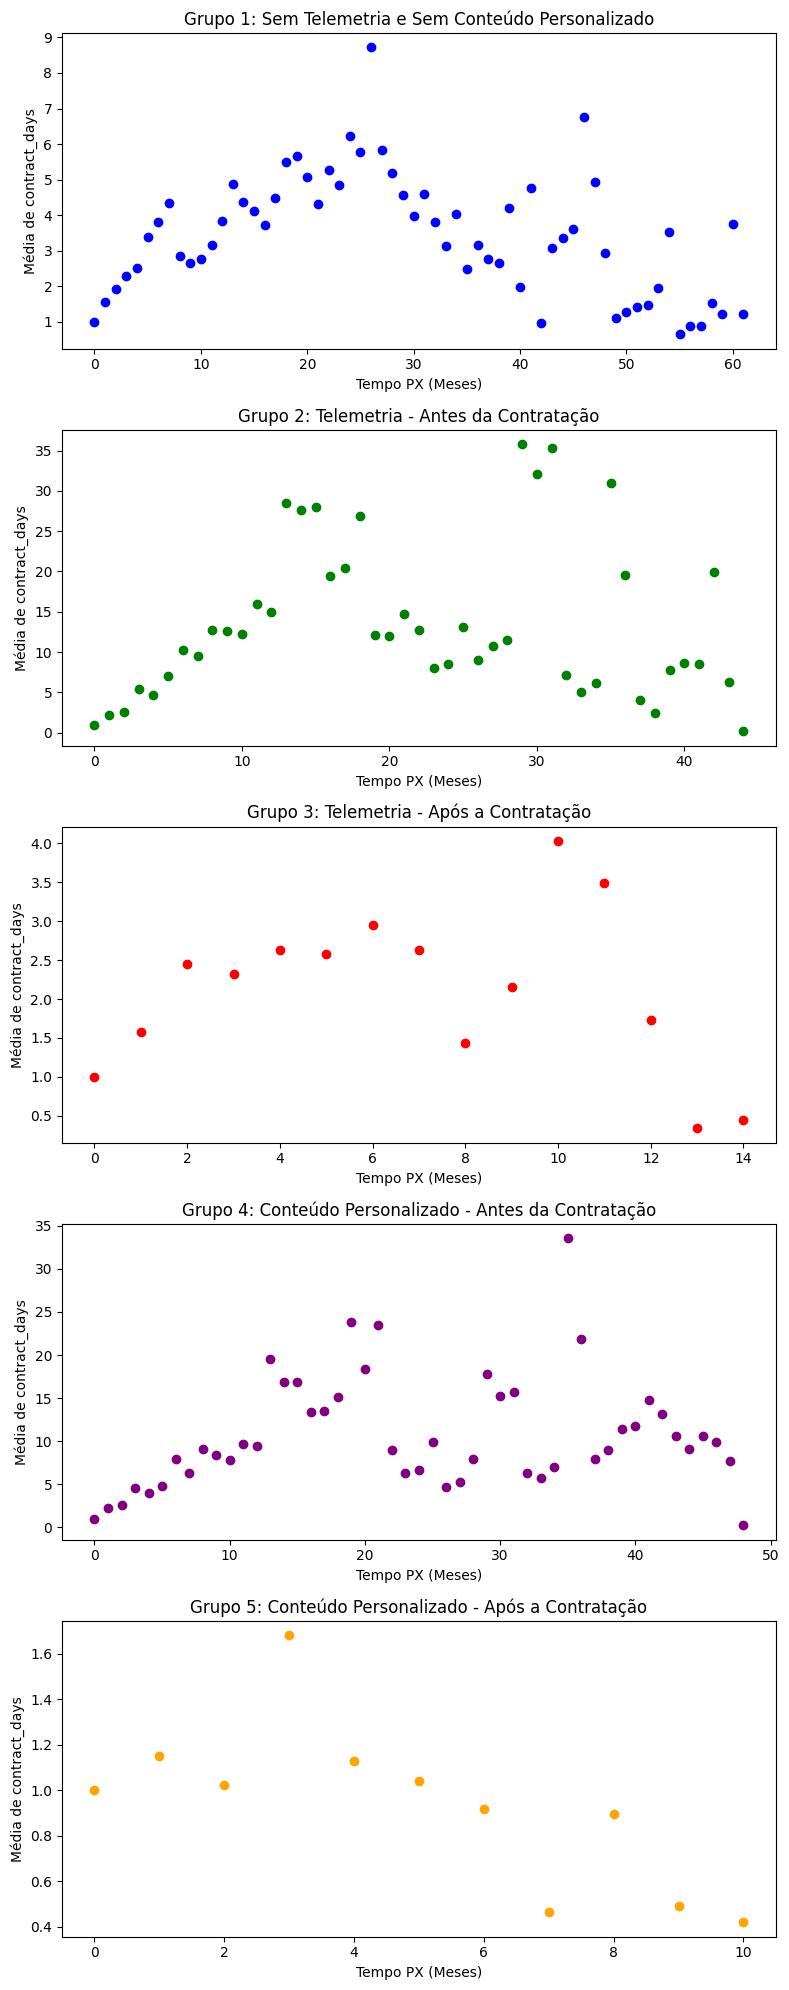

In [11]:
import matplotlib.pyplot as plt

# Cria uma figura com 5 subplots (um para cada grupo)
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
axs[0].scatter(group1_mean['mes_inteiro'], group1_mean['contract_days'], color='blue')
axs[0].set_title("Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado")
axs[0].set_xlabel("Tempo PX (Meses)")
axs[0].set_ylabel("Média de contract_days")

# Grupo 2: Empresas com telemetria, antes da contratação 
axs[1].scatter(group2_mean['mes_inteiro'], group2_mean['contract_days'], color='green')
axs[1].set_title("Grupo 2: Telemetria - Antes da Contratação")
axs[1].set_xlabel("Tempo PX (Meses)")
axs[1].set_ylabel("Média de contract_days")

# Grupo 3: Empresas com telemetria, após a contratação 
axs[2].scatter(group3_mean['mes_inteiro'], group3_mean['contract_days'], color='red')
axs[2].set_title("Grupo 3: Telemetria - Após a Contratação")
axs[2].set_xlabel("Tempo PX (Meses)")
axs[2].set_ylabel("Média de contract_days")

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
axs[3].scatter(group4_mean['mes_inteiro'], group4_mean['contract_days'], color='purple')
axs[3].set_title("Grupo 4: Conteúdo Personalizado - Antes da Contratação")
axs[3].set_xlabel("Tempo PX (Meses)")
axs[3].set_ylabel("Média de contract_days")

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
axs[4].scatter(group5_mean['mes_inteiro'], group5_mean['contract_days'], color='orange')
axs[4].set_title("Grupo 5: Conteúdo Personalizado - Após a Contratação")
axs[4].set_xlabel("Tempo PX (Meses)")
axs[4].set_ylabel("Média de contract_days")

plt.tight_layout()
plt.show()


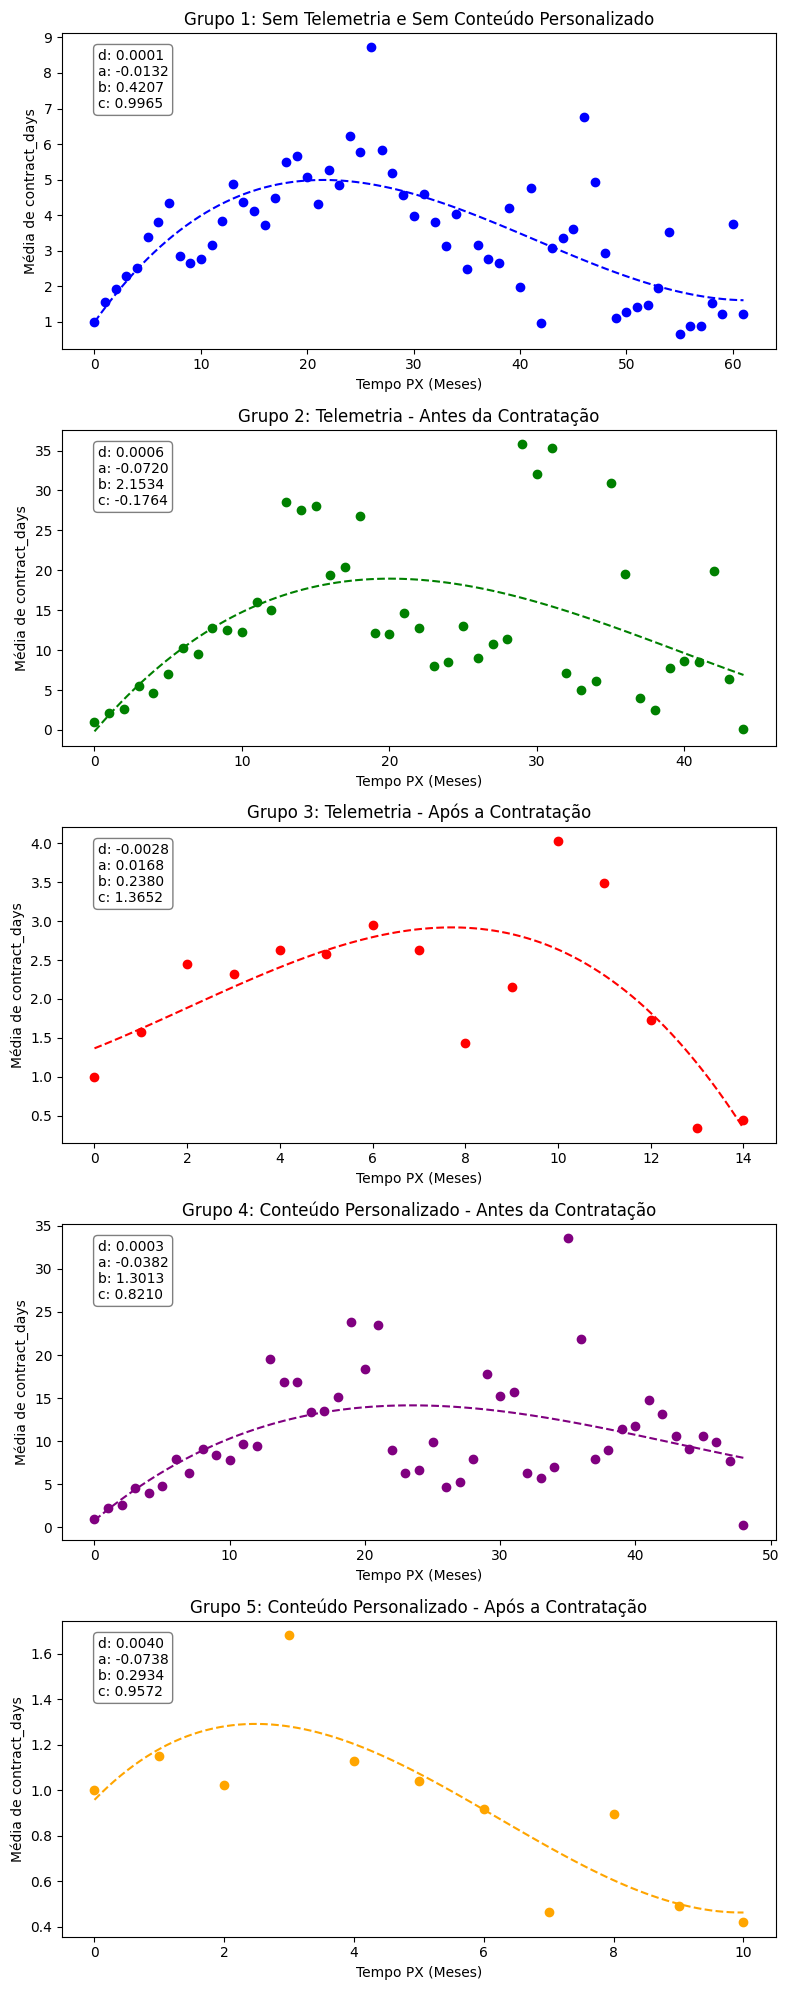

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cubic_regression(ax, df, title, color):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Plota os dados em scatter
    ax.scatter(x, y, color=color)
    
    # Calcula os parâmetros da regressão cúbica (grau 3)
    coeffs = np.polyfit(x, y, 3)
    d, a, b, c = coeffs  # Coeficientes do polinômio: d*x³ + a*x² + b*x + c
    
    # Gera valores para a linha de regressão
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = d * x_line**3 + a * x_line**2 + b * x_line + c
    ax.plot(x_line, y_line, color=color, linestyle='--')
    
    # Anota os parâmetros da regressão no gráfico
    textstr = f"d: {d:.4f}\na: {a:.4f}\nb: {b:.4f}\nc: {c:.4f}"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Define título e rótulos dos eixos
    ax.set_title(title)
    ax.set_xlabel("Tempo PX (Meses)")
    ax.set_ylabel("Média de contract_days")

# Cria uma figura com 5 subplots (um para cada grupo)
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
plot_cubic_regression(axs[0], group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado", 'blue')

# Grupo 2: Empresas com telemetria, antes da contratação 
plot_cubic_regression(axs[1], group2_mean, "Grupo 2: Telemetria - Antes da Contratação", 'green')

# Grupo 3: Empresas com telemetria, após a contratação 
plot_cubic_regression(axs[2], group3_mean, "Grupo 3: Telemetria - Após a Contratação", 'red')

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
plot_cubic_regression(axs[3], group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação", 'purple')

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
plot_cubic_regression(axs[4], group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação", 'orange')

plt.tight_layout()
plt.show()


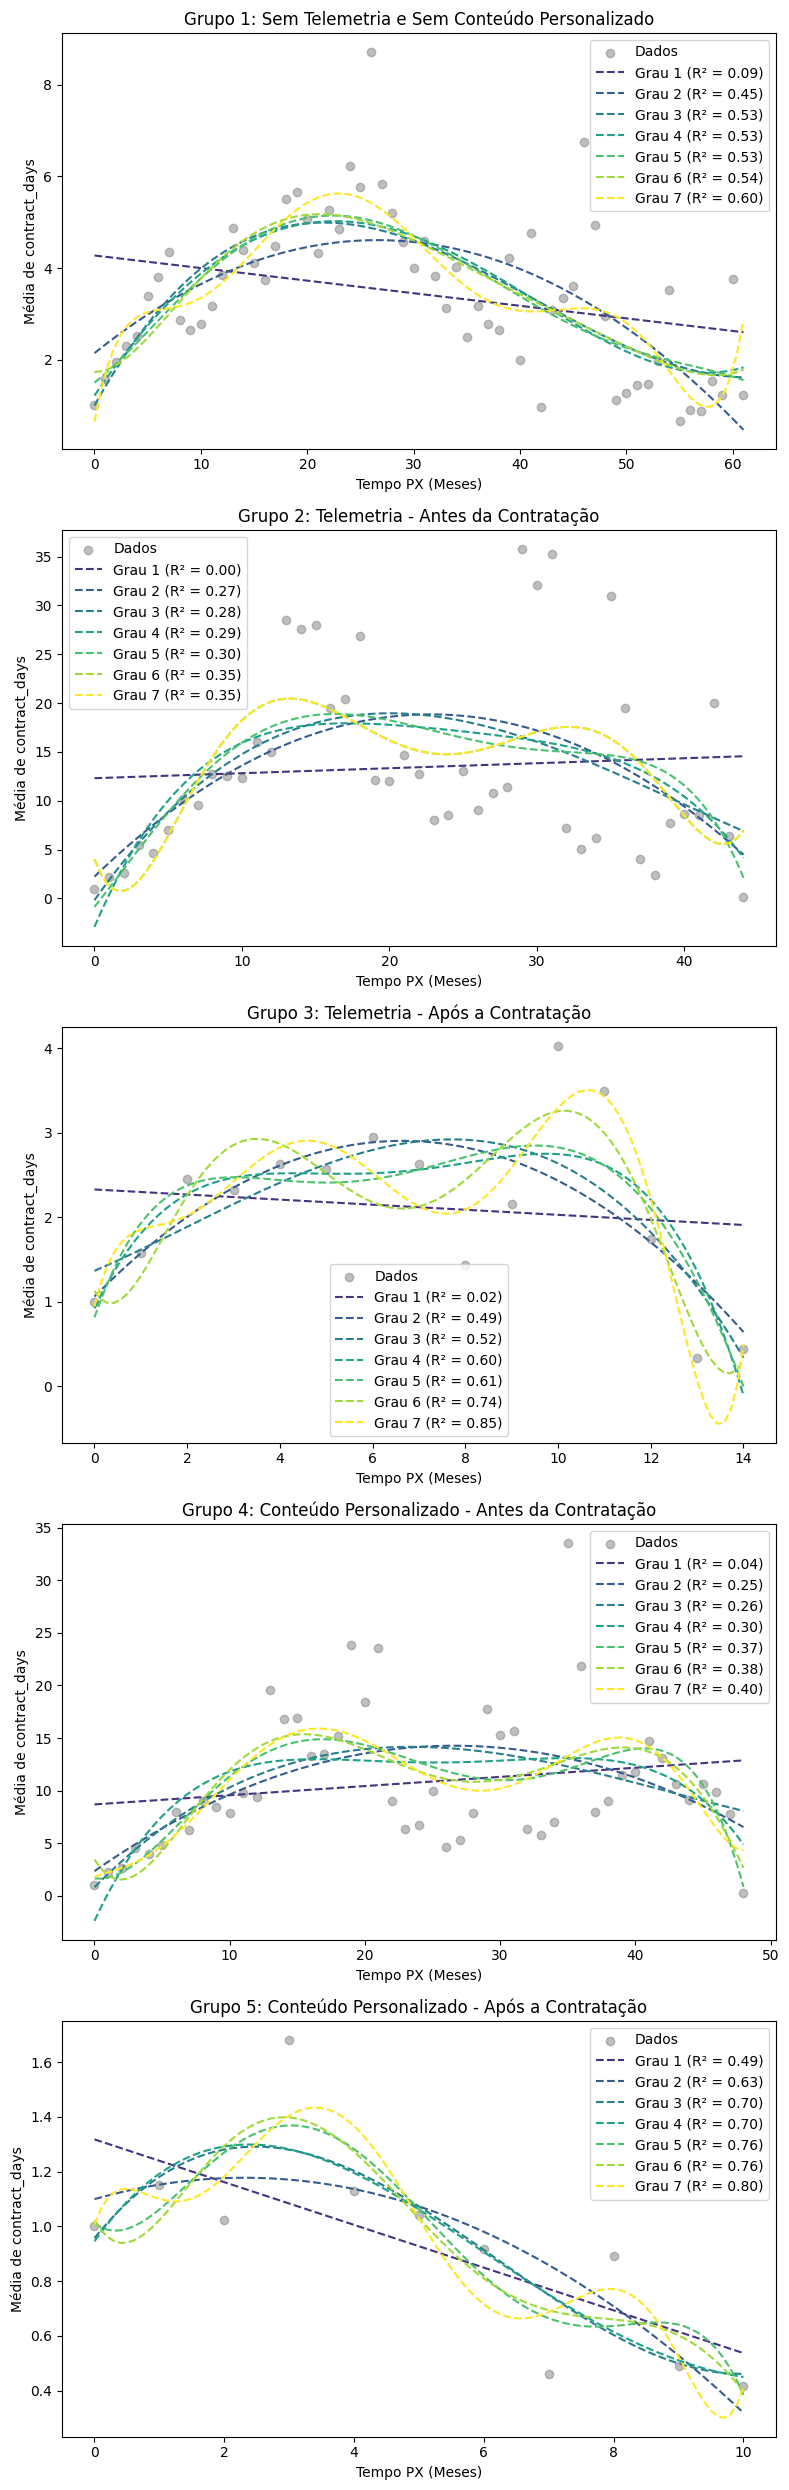

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_r2(x, y, coeffs):
    """
    Calcula o coeficiente de determinação R² para um ajuste polinomial.
    """
    y_pred = np.polyval(coeffs, x)
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res / ss_tot

def plot_multiple_regressions(ax, df, title):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Plota os pontos de dados
    ax.scatter(x, y, color='gray', alpha=0.5, label='Dados')
    
    # Define uma paleta de cores para os diferentes graus utilizando um colormap
    cmap = plt.cm.viridis
    degrees = range(1, 8)  # graus de 1 a 7
    
    # Para cada grau de regressão, realiza o ajuste, calcula R² e plota a linha
    for degree in degrees:
        coeffs = np.polyfit(x, y, degree)
        x_line = np.linspace(x.min(), x.max(), 100)
        y_line = np.polyval(coeffs, x_line)
        r2 = calculate_r2(x, y, coeffs)
        color = cmap(degree / 7)  # normaliza para o colormap
        ax.plot(x_line, y_line, linestyle='--', color=color,
                label=f'Grau {degree} (R² = {r2:.2f})')
    
    # Configura o gráfico
    ax.set_title(title)
    ax.set_xlabel("Tempo PX (Meses)")
    ax.set_ylabel("Média de contract_days")
    ax.legend()

# Cria uma figura com 5 subplots (um para cada grupo)
fig, axs = plt.subplots(5, 1, figsize=(8, 25))

# Ajuste para cada grupo de dados
plot_multiple_regressions(axs[0], group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado")
plot_multiple_regressions(axs[1], group2_mean, "Grupo 2: Telemetria - Antes da Contratação")
plot_multiple_regressions(axs[2], group3_mean, "Grupo 3: Telemetria - Após a Contratação")
plot_multiple_regressions(axs[3], group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação")
plot_multiple_regressions(axs[4], group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação")

plt.tight_layout()
plt.show()


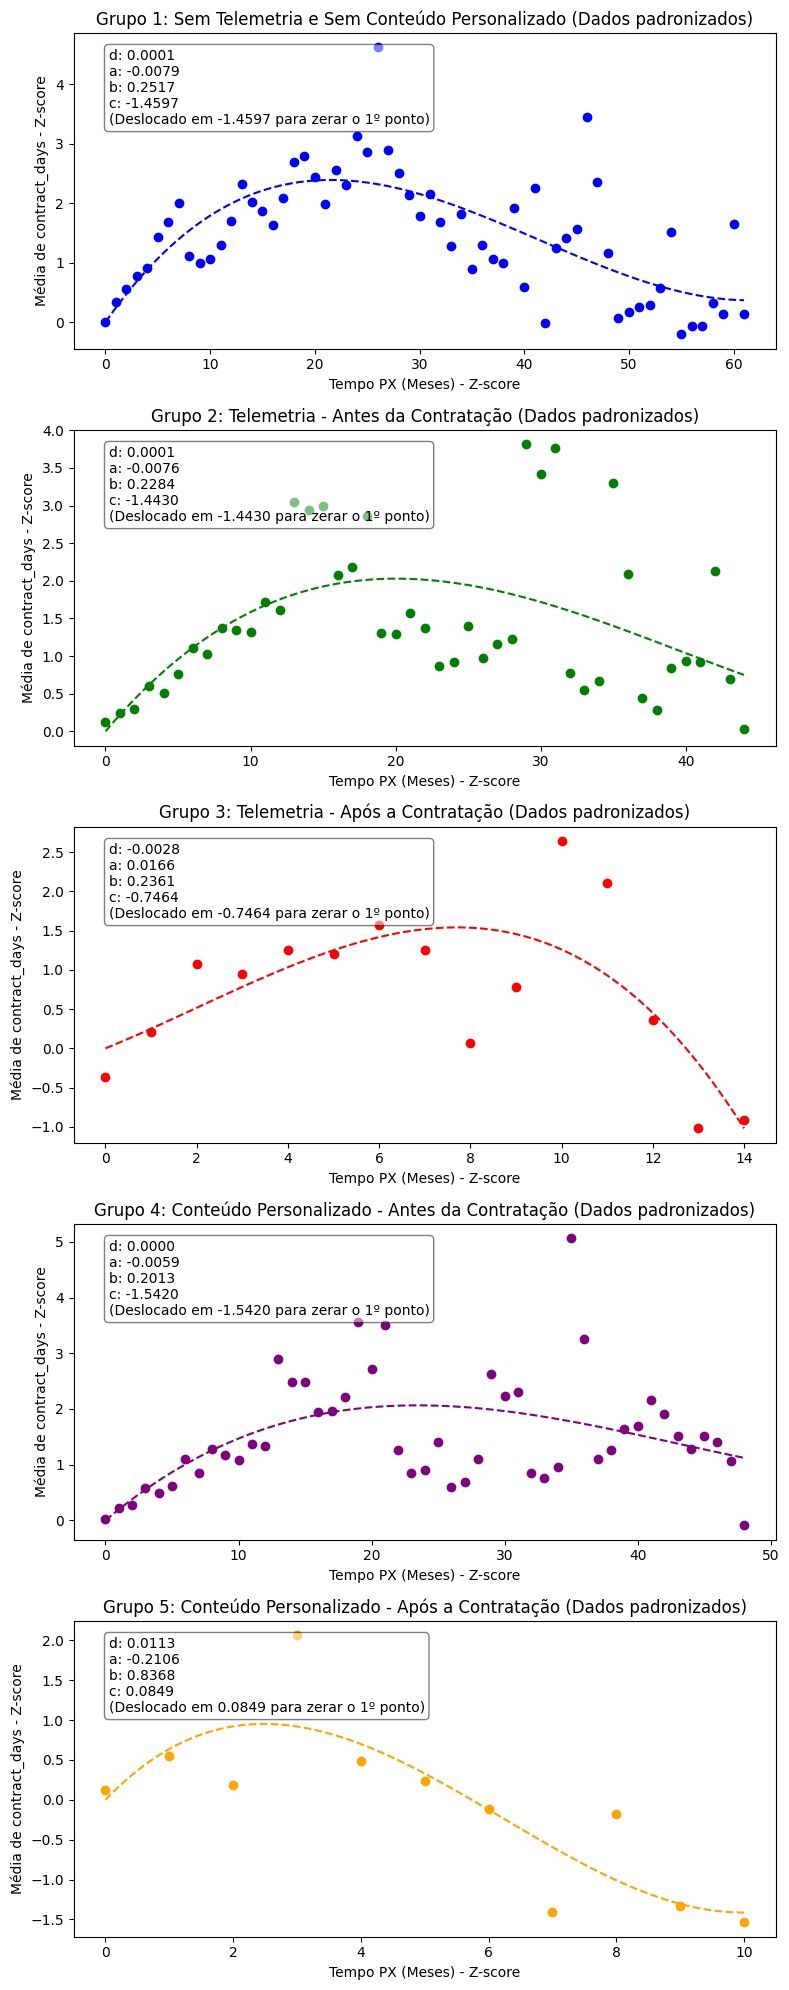

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cubic_regression(ax, df, title, color):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Aplica o z-score nos dados
    x_z = x
    y_z = (y - np.mean(y)) / np.std(y)
    

    
    # Calcula os parâmetros da regressão cúbica (grau 3) sobre os dados padronizados
    coeffs = np.polyfit(x_z, y_z, 3)
    # Coeficientes do polinômio: d*x³ + a*x² + b*x + c
    d, a, b, c = coeffs
    
    # Gera valores para a linha de regressão
    x_line = np.linspace(x_z.min(), x_z.max(), 100)
    y_line = d * x_line**3 + a * x_line**2 + b * x_line + c
    
    # Ajusta a curva para que o primeiro ponto seja igual a zero
    offset = y_line[0]
    y_line_adjusted = y_line - offset
    y_z = y_z - offset
    # Plota os dados padronizados
    ax.scatter(x_z, y_z, color=color)

    # Plota a linha ajustada
    ax.plot(x_line, y_line_adjusted, color=color, linestyle='--')
    
    # Anota os parâmetros da regressão no gráfico (observando que o ajuste foi deslocado)
    textstr = (f"d: {d:.4f}\na: {a:.4f}\nb: {b:.4f}\nc: {c:.4f}\n"
               f"(Deslocado em {offset:.4f} para zerar o 1º ponto)")
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Configura o gráfico
    ax.set_title(title + " (Dados padronizados)")
    ax.set_xlabel("Tempo PX (Meses) - Z-score")
    ax.set_ylabel("Média de contract_days - Z-score")

# Cria uma figura com 5 subplots (um para cada grupo)
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
plot_cubic_regression(axs[0], group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado", 'blue')

# Grupo 2: Empresas com telemetria, antes da contratação 
plot_cubic_regression(axs[1], group2_mean, "Grupo 2: Telemetria - Antes da Contratação", 'green')

# Grupo 3: Empresas com telemetria, após a contratação 
plot_cubic_regression(axs[2], group3_mean, "Grupo 3: Telemetria - Após a Contratação", 'red')

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
plot_cubic_regression(axs[3], group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação", 'purple')

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
plot_cubic_regression(axs[4], group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação", 'orange')

plt.tight_layout()
plt.show()


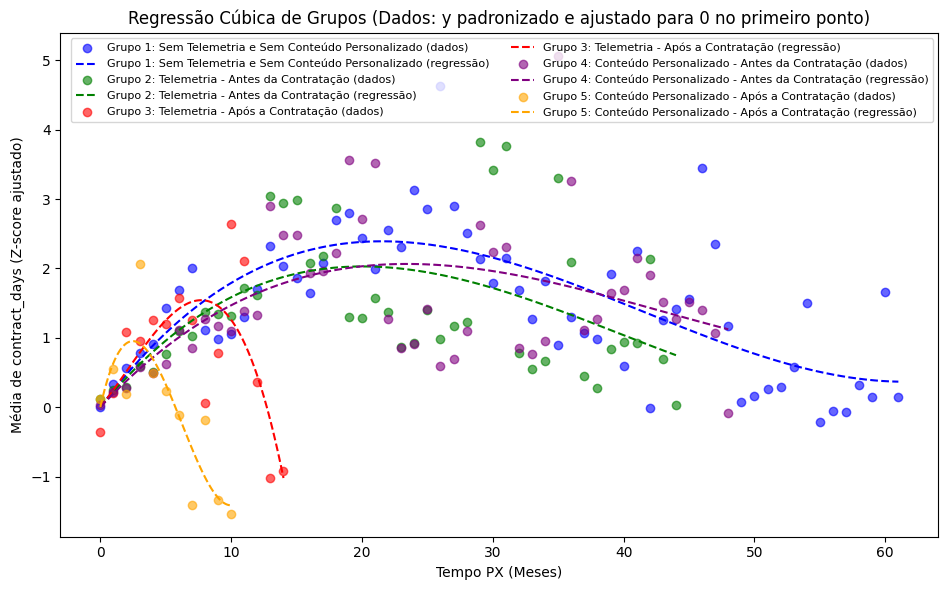

Coeficientes do Grupo 1: d: 0.0001, a: -0.0079, b: 0.2517, c: -1.4597
Offset: -1.4597
Coeficientes do Grupo 2: d: 0.0001, a: -0.0076, b: 0.2284, c: -1.4430
Offset: -1.4430
Coeficientes do Grupo 3: d: -0.0028, a: 0.0166, b: 0.2361, c: -0.7464
Offset: -0.7464
Coeficientes do Grupo 4: d: 0.0000, a: -0.0059, b: 0.2013, c: -1.5420
Offset: -1.5420
Coeficientes do Grupo 5: d: 0.0113, a: -0.2106, b: 0.8368, c: 0.0849
Offset: 0.0849


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cubic_regression_overlay(ax, df, label, color):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Aplica o z-score apenas em y (mantendo x original)
    y_z = (y - np.mean(y)) / np.std(y)
    
    # Calcula os parâmetros da regressão cúbica (grau 3) sobre os dados
    coeffs = np.polyfit(x, y_z, 3)
    # Coeficientes do polinômio: d*x³ + a*x² + b*x + c
    d, a, b, c = coeffs
    
    # Gera valores para a linha de regressão
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = d * x_line**3 + a * x_line**2 + b * x_line + c
    
    # Ajusta a curva para que o primeiro ponto seja zero
    offset = y_line[0]
    y_line_adjusted = y_line - offset
    y_z_adjusted = y_z - offset
    
    # Plota os dados e a linha de regressão
    ax.scatter(x, y_z_adjusted, color=color, alpha=0.6, label=f"{label} (dados)")
    ax.plot(x_line, y_line_adjusted, color=color, linestyle='--', label=f"{label} (regressão)")
    
    # Retorna uma string com os coeficientes e offset para inclusão opcional na legenda
    info = f"d: {d:.4f}, a: {a:.4f}, b: {b:.4f}, c: {c:.4f}\nOffset: {offset:.4f}"
    return info

# Cria a figura e um único eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plot de todos os grupos sobre o mesmo gráfico
info1 = plot_cubic_regression_overlay(ax, group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado", 'blue')
info2 = plot_cubic_regression_overlay(ax, group2_mean, "Grupo 2: Telemetria - Antes da Contratação", 'green')
info3 = plot_cubic_regression_overlay(ax, group3_mean, "Grupo 3: Telemetria - Após a Contratação", 'red')
info4 = plot_cubic_regression_overlay(ax, group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação", 'purple')
info5 = plot_cubic_regression_overlay(ax, group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação", 'orange')

# Configurações finais do gráfico
ax.set_title("Regressão Cúbica de Grupos (Dados: y padronizado e ajustado para 0 no primeiro ponto)")
ax.set_xlabel("Tempo PX (Meses)")
ax.set_ylabel("Média de contract_days (Z-score ajustado)")
ax.legend(loc='best', fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

# Opcional: impressão dos coeficientes de cada grupo no console
print("Coeficientes do Grupo 1:", info1)
print("Coeficientes do Grupo 2:", info2)
print("Coeficientes do Grupo 3:", info3)
print("Coeficientes do Grupo 4:", info4)
print("Coeficientes do Grupo 5:", info5)
